In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import random
import water_main_predictions
import time

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score, plot_confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, train_test_split
import shap
import lightgbm as lgb 

pd.set_option('max_colwidth', 80)

In [3]:
columns = ['TARGET_FID', 'Length', 'Install_year', 'Slope', 'Width', 'Break_Yr',
       'Target', 'AGE',
       'Process_year']

In [4]:
sea_df = pd.read_csv("compat_sea.csv")
tac_df = pd.read_csv("compat_tac.csv")

train_sea = sea_df[~sea_df["Process_year"].eq(2020)]
train_tac = tac_df[~tac_df["Process_year"].eq(2020)]
val_sea = sea_df[sea_df["Process_year"].eq(2020)]
val_tac = tac_df[tac_df["Process_year"].eq(2020)]

In [49]:
param_list = {
      'n_estimators': [50],
      'max_depth': [30]
    } 
param = {}
for key in param_list.keys():
    val = random.choice(param_list[key])
    param[key] = val

In [5]:
# Used to build a list containing dictionaries w every compination of params
# from param list, start with a list containing one dict (src), 
# then call for each param (cross, keyword)
def cross_params(src, cross, keyword):
    combos = []
    for d in src:
        for val in cross:
            cpy = d.copy()
            cpy[keyword] = val
            combos.append(cpy)
    return combos

# Uses cross_params to get list of all parameter combinations 
def get_param_combos(param_list):
    param_combos = [{}]
    for kw in param_list:
        param_combos = cross_params(param_combos, param_list[kw], kw)
    return param_combos

In [6]:
def rand_param_search(data, param_list, classifier_fn, n_val=2, threshold=0.1, print_results=True):
    """

    """
    best_score = -1.0 
    best_param = {}
    param_combos = get_param_combos(param_list)
    for param in param_combos:
        print("using the following parameters:")
        print(param)
        avgs = water_main_predictions.crossval.crossval_by_year(data, classifier_fn, param, n_val, threshold, print_results, under_sample=True)
        print(avgs[0])
        print(avgs[1])
        print(avgs[2])
        print()
        if avgs[0] > best_score:
            best_param = param
            best_score = avgs[0]
    
    
    return best_param, best_score

In [34]:
best_score, best_param = rand_param_search(sea_df[columns], param_list, RandomForestClassifier)
print(best_param)
print(best_score)

using the following parameters:
{'n_estimators': 50, 'max_depth': 30}


AttributeError: module 'water_main_predictions' has no attribute 'crossval'

In [ ]:
print(best_param)
print(best_score)

0.7422383115676469
{'n_estimators': 50, 'max_depth': 30}


## Temporal validation


In [23]:
print(sea_df['Process_year'].min())
print(sea_df['Process_year'].max())

2010
2020


In [46]:
sea_df

,TARGET_FID,Length,Install_year,Slope,Width,Break_Yr,Target,AGE,Nearby_breaks_1yr,Process_year
0,1,314.79,1972,0.0,8.0,NaN,0,38,0,2010
1,2,363.39,1972,4.0,8.0,NaN,0,38,0,2010
2,3,323.51,1972,4.0,8.0,NaN,0,38,0,2010
3,4,329.13,1928,6.0,12.0,NaN,0,82,0,2010
4,5,273.64,1928,4.0,18.0,NaN,0,82,0,2010
...,...,...,...,...,...,...,...,...,...,...
752452,39078,281.77,1948,8.0,8.0,2020.0,1,72,0,2020
752453,17346,327.73,1977,0.0,8.0,2020.0,1,43,1,2020
752454,65861,56.73,1957,6.0,6.0,2020.0,1,63,0,2020
752455,65861,56.73,1957,6.0,6.0,2020.0,1,63,0,2020


In [47]:
def get_continious_subset(df, min_year, max_year):
    df = df[(df['Process_year'] >= min_year) & (df['Process_year'] <= max_year)]
    df = df.drop(['TARGET_FID', 'Process_year', 'Break_Yr'], axis=1) \
                    .dropna(axis=0) \
                    .astype(np.float32)
    return df

In [58]:
def temporal_cross_validation(df, classifier_fn, params_dict, n_years, threshold=0.5, print_results=True, normalize_data=False, under_sample=False):

    scores = []
    t_init = time.perf_counter()
    
    min_year = df['Process_year'].min()
    max_year = df['Process_year'].max()
    for i, year in enumerate(np.arange(min_year, max_year+1-n_years, 1)):
        train_df = get_continious_subset(df, year, year+n_years-1)
        val_df = df[df['Process_year'] == year+n_years]
        val_df = val_df.drop(['TARGET_FID', 'Process_year', 'Break_Yr'], axis=1) \
            .dropna(axis=0) \
            .astype(np.float32)

        classifier = classifier_fn()
        classifier.set_params(**params_dict)

        x_train = train_df.drop('Target', axis=1)
        y_train = train_df['Target']

        if under_sample:
            x_train, y_train = ClusterCentroids().fit_resample(x_train, y_train)

        if normalize_data:
          scaler = StandardScaler()
          scaler.fit(x_train)
          x_train = scaler.transform(x_train)

        classifier.fit(x_train, y_train)

        # make predictions on evaluation dataset
        x_val = val_df.drop('Target', axis=1)
        y_val = val_df['Target']
        if normalize_data:
          x_val = scaler.transform(x_val)

        pred_prob = classifier.predict_proba(x_val)
        preds = (pred_prob[:,1] >= threshold).astype(bool) 

        recall = recall_score(y_true=y_val, y_pred=preds)
        precision = precision_score(y_true=y_val, y_pred=preds)

        bal_acc = balanced_accuracy_score(y_true=y_val, y_pred=preds)
        train_preds = classifier.predict(x_train)

        train_recall = recall_score(y_train, train_preds)
        train_precision = precision_score(y_train, train_preds)

        train_bal_acc = balanced_accuracy_score(y_train, train_preds)

        if (print_results):
            print(f'Cross-validation iteration {i+1} of {max_year-min_year-n_years} results:')
            print(f'Balanced accuracy = {bal_acc:.4f}')
            print(f'Recall            = {recall:.4f}')
            print(f'Precision         = {precision:.4f}')
            print()
            print(f'Training set balanced accuracy = {train_bal_acc}')
            print(f'Train Recall            = {train_recall:.4f}')
            print(f'Train Precision         = {train_precision:.4f}')

        scores.append((bal_acc, recall, precision))
    
        avgs = np.array(scores).mean(axis=0)


    if (print_results):
        print(f'Finished cross-validation (took {time.perf_counter() - t_init:.2f} seconds).')
        print(f'Avg. Balanced Acc = {avgs[0]:.4f}')
        print(f'Avg. Recall       = {avgs[1]:.4f}')
        print(f'Avg. Precision    = {avgs[2]:.4f}')
        print()


    return avgs


In [69]:
temporal_cross_validation(sea_df, RandomForestClassifier, {'n_estimators': 50, 'max_depth': 30} , 10, 0.7)

Cross-validation iteration 1 of 0 results:
Balanced accuracy = 0.6372
Recall            = 0.2744
Precision         = 1.0000

Training set balanced accuracy = 0.9223731161683035
Train Recall            = 0.8449
Train Precision         = 0.9487
Finished cross-validation (took 41.74 seconds).
Avg. Balanced Acc = 0.6372
Avg. Recall       = 0.2744
Avg. Precision    = 1.0000



array([0.63719512, 0.27439024, 1.        ])

In [170]:
classifier = RandomForestClassifier(n_estimators=50, max_depth=30)

train_df = train_sea.drop(['TARGET_FID', 'Process_year', 'Break_Yr'], axis=1) \
            .dropna(axis=0) \
            .astype(np.float32)

val_df = val_sea.drop(['TARGET_FID', 'Process_year', 'Break_Yr'], axis=1) \
            .dropna(axis=0) \
            .astype(np.float32)

x_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
classifier.fit(x_train, y_train)
#plot_confusion_matrix()

RandomForestClassifier(max_depth=30, n_estimators=50)

In [171]:
# make predictions on evaluation dataset
x_val = val_df.drop('Target', axis=1)
y_val = val_df['Target']

pred_prob_all = classifier.predict_proba(x_val)
inds = np.argsort(-pred_prob_all[:,1])

pred_prob  = pred_prob_all[inds[:], 1]

preds = (pred_prob >= 0.2).astype(bool) 

y_val = np.array(y_val)[inds[:]]

recall = recall_score(y_true=y_val, y_pred=preds)
precision = precision_score(y_true=y_val, y_pred=preds)

bal_acc = balanced_accuracy_score(y_true=y_val, y_pred=preds)
train_preds = classifier.predict(x_train)

train_recall = recall_score(y_train, train_preds)
train_precision = precision_score(y_train, train_preds)

train_bal_acc = balanced_accuracy_score(y_train, train_preds)

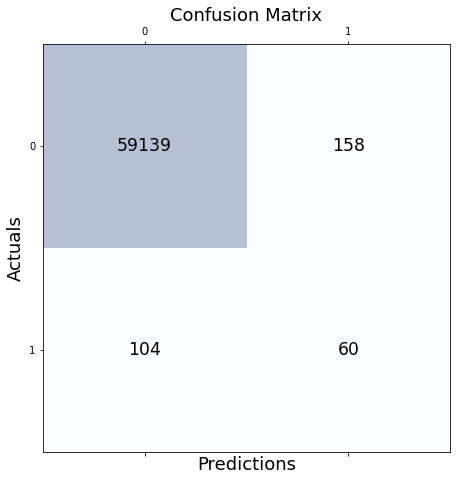

In [174]:
conf_matrix = confusion_matrix(y_val, preds, labels=[0, 1])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

(array([397., 166.,  36.,  31.,   6.,   5.,   1.,   7.,   6.,  34.]),
 array([0.06666667, 0.16      , 0.25333333, 0.34666667, 0.44      ,
        0.53333333, 0.62666667, 0.72      , 0.81333333, 0.90666667,
        1.        ]),
 <BarContainer object of 10 artists>)

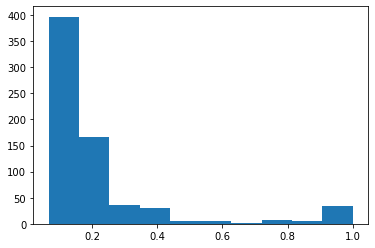

In [126]:
inds = np.argsort(-pred_prob[:,1])
plt.hist(pred_prob[inds[:689],1])

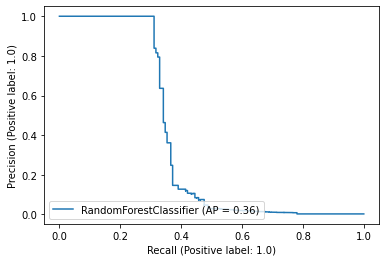

In [90]:
plot_precision_recall_curve(classifier, x_val, y_val)

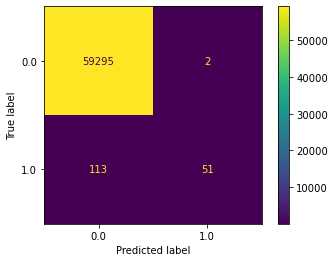

In [91]:
plot_confusion_matrix(classifier, x_val, y_val)